---
format:
    html:
        embed-resources: true
---

In [1]:
library(tidyverse)
library(leaps) # Subset selection
library(glmnet) # Ridge/Lasso
library(gam)
library(tree)
library(e1071)
library(randomForest)
library(kableExtra)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: splines

Loading required package: foreach


Attaching package: 'foreach'


The following objects are masked from 'package:purrr':

    accumulate, when


Loaded gam 1.22-3


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomFor

In [2]:
# Read data file
df = read.csv("./data/cleaned_listing_dc.csv")
cleaned_df = df %>% dplyr::select(host_has_profile_pic, host_identity_verified, longitude, latitude, accommodates, bathrooms, beds, price, number_of_reviews, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, instant_bookable, reviews_per_month, host_length)

# Separate non-numeric columns
non_numeric_cols = cleaned_df[, !sapply(cleaned_df, is.numeric)]
numeric_cols = cleaned_df[, sapply(cleaned_df, is.numeric)]

# Normalize numeric columns
normalized_numeric_cols = as.data.frame(scale(numeric_cols))

# Combine back together
cleaned_df = cbind(normalized_numeric_cols, non_numeric_cols)
cleaned_df$price = log(df$price)
# cleaned_df$price = df$price
head(cleaned_df)

,longitude,latitude,accommodates,bathrooms,beds,price,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_length,host_has_profile_pic,host_identity_verified,instant_bookable
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,-0.8981083,0.3509227,-0.5611544,-0.5270125,-0.9351483,4.094345,0.1733423,-0.75123207,-0.3074395,-1.90391199,-0.126906964,-0.08933873,0.403875219,-0.6331848,-0.8332018,2.408087,t,t,f
2,-2.7730365,0.3973292,-0.9799366,-0.5270125,-0.2209855,4.189655,0.1252332,0.07332251,-0.1211679,0.25322286,0.247736693,0.13749832,0.082956498,0.3099247,-0.8383445,2.295420,t,t,f
3,-2.0631912,0.6554654,-0.1423722,-0.5270125,0.4931773,4.442651,3.2138381,-0.49533582,-0.4937111,-0.53383986,-0.002025745,0.08078906,0.189929405,-0.2508431,0.1336245,2.214300,t,t,f
4,-0.6145604,0.7441350,-0.9799366,-0.5270125,-0.2209855,4.828314,-0.3847234,0.21548709,0.3445110,0.16577145,0.435058522,0.33598074,0.002726818,0.3863930,-0.9977680,2.134081,t,t,f
5,0.6870938,-0.4089840,-0.1423722,-0.5270125,0.4931773,6.469250,-0.6252689,0.01645667,-0.9593901,-1.55410634,-0.345449097,-0.28782115,0.644564260,0.1569880,-1.0749084,1.980854,t,t,f
6,0.1954373,2.3244425,-1.3987188,-0.5270125,-0.9351483,4.174387,-0.6445126,0.67041376,-0.6489375,0.04916956,0.435058522,0.42104463,-1.494893881,-0.7351426,-1.0800511,2.195372,t,t,f


In [3]:
colnames(cleaned_df)

[1] "longitude"                   "latitude"                   
 [3] "accommodates"                "bathrooms"                  
 [5] "beds"                        "price"                      
 [7] "number_of_reviews"           "review_scores_rating"       
 [9] "review_scores_accuracy"      "review_scores_cleanliness"  
[11] "review_scores_checkin"       "review_scores_communication"
[13] "review_scores_location"      "review_scores_value"        
[15] "reviews_per_month"           "host_length"                
[17] "host_has_profile_pic"        "host_identity_verified"     
[19] "instant_bookable"

In [4]:
# Train and test split
set.seed(0223)
indices = sample(nrow(cleaned_df), size = nrow(cleaned_df)*0.8, replace = FALSE)
train = cleaned_df[indices,]
test = cleaned_df[-indices,]

# Subset Selection

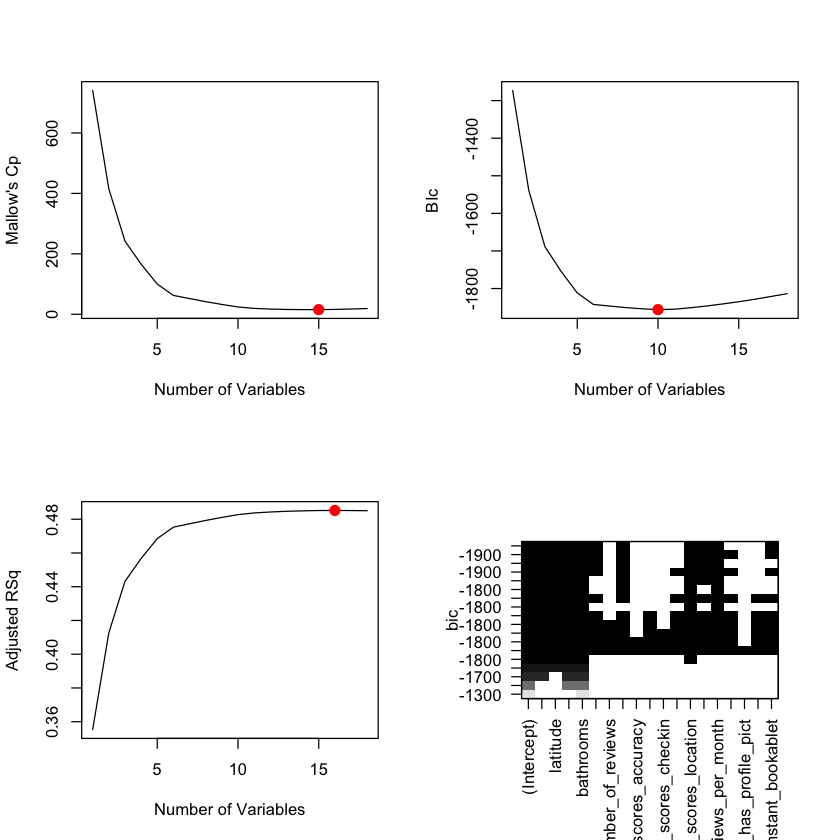

In [5]:
# Best subset selection
regfit.best = regsubsets(price~.,train, nvmax = ncol(train))
reg.summary=summary(regfit.best)

par(mfrow=c(2,2))
plot(reg.summary$cp,xlab="Number of Variables",ylab="Mallow's Cp",type="l")
points(which.min(reg.summary$cp),reg.summary$cp[which.min(reg.summary$cp)],col="red",cex=2,pch=20)

plot(reg.summary$bic,xlab="Number of Variables",ylab="BIc",type="l")
points(which.min(reg.summary$bic),reg.summary$bic[which.min(reg.summary$bic)],col="red",cex=2,pch=20)

plot(reg.summary$adjr2,xlab="Number of Variables",ylab="Adjusted RSq",type="l")
points(which.max(reg.summary$adjr2),reg.summary$adjr2[which.max(reg.summary$adjr2)],col="red",cex=2,pch=20)

plot(regfit.best,scale="bic")

In [6]:
print(coef(regfit.best,which.min(summary(regfit.best)$bic)))

           (Intercept)              longitude               latitude 
            4.96099910            -0.10660395            -0.07203328 
          accommodates              bathrooms                   beds 
            0.18071113             0.17078764             0.04470738 
  review_scores_rating review_scores_location    review_scores_value 
            0.05846420             0.05013689            -0.04141853 
     reviews_per_month      instant_bookablet 
           -0.04338568            -0.05023312 


In [7]:
# coef(regfit.best,which.min(summary(regfit.best)$bic)) %>% kbl() %>% kable_styling(latex_options = "striped")

# LASSO

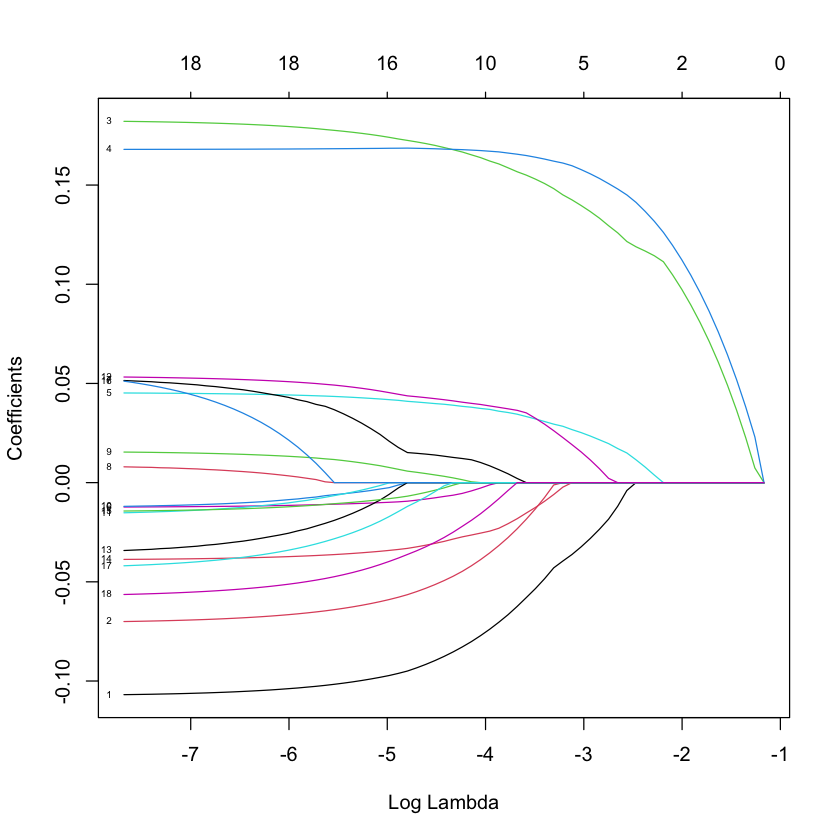

[1] "Test MSE (lasso):  0.12958460254972"

[1] "R2 (lasso):  0.54229570728423"

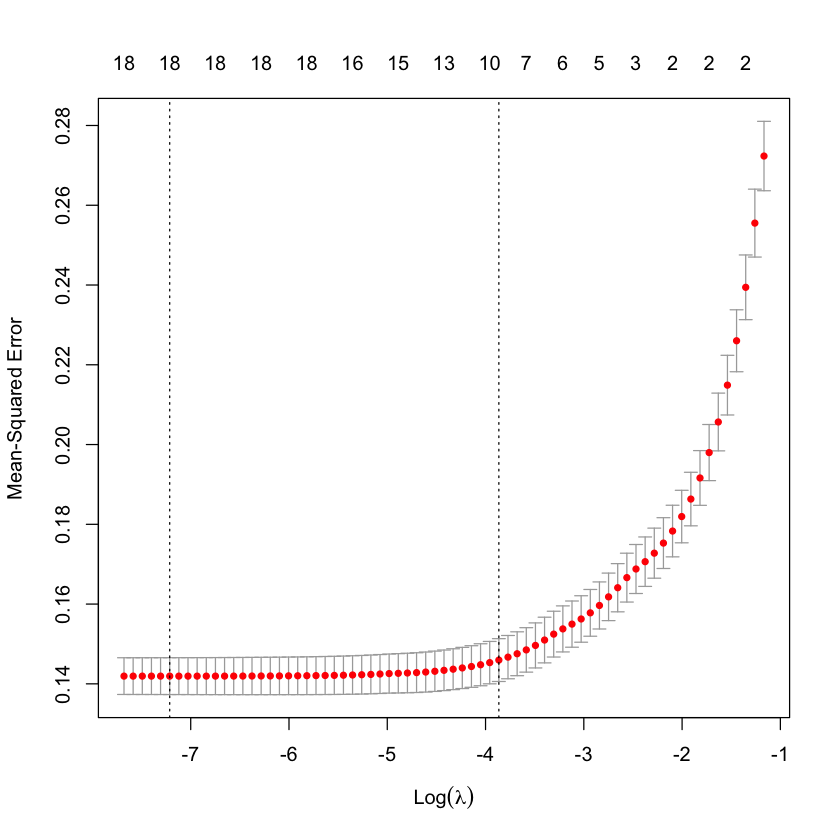

In [8]:
# Train
x = model.matrix(price ~ .,train)[,-1]
y = train$price

lasso.fit = glmnet(x, y, alpha = 1)
plot(lasso.fit, xvar="lambda", label = TRUE)

# 10 fold CV lasso
cv.lasso.fit = cv.glmnet(x, y, alpha = 1, nfolds = 10)
plot(cv.lasso.fit)

# Test
x_test = model.matrix(price ~ .,test)[,-1]
y_test = test$price

# LASSO regression
y_pred = predict.glmnet(lasso.fit, s = cv.lasso.fit$lambda.min, newx = x_test)
error = mean((test$price - y_pred)**2)
paste("Test MSE (lasso): ",error)

R2 = cor(y_test, y_pred)**2
paste("R2 (lasso): ", R2[1])

In [9]:
coef(cv.lasso.fit, cv.lasso.fit$lambda.1se)

19 x 1 sparse Matrix of class "dgCMatrix"
                                      s1
(Intercept)                  4.948988337
longitude                   -0.070358430
latitude                    -0.031712799
accommodates                 0.160645294
bathrooms                    0.166720989
beds                         0.036011889
number_of_reviews            .          
review_scores_rating         0.006530718
review_scores_accuracy       .          
review_scores_cleanliness    .          
review_scores_checkin        .          
review_scores_communication  .          
review_scores_location       0.037954653
review_scores_value          .          
reviews_per_month           -0.022991874
host_length                  .          
host_has_profile_pict        .          
host_identity_verifiedt      .          
instant_bookablet           -0.008103817

# Linear Regression

In [10]:
# Linear regressoin
lin.fit = lm(price ~ ., data = train)

# Removing unsignificant variables
lin.fit2 = lm(price ~ .-number_of_reviews-review_scores_accuracy-review_scores_cleanliness-review_scores_checkin-review_scores_communication-host_has_profile_pic, data = train)
stargazer::stargazer(lin.fit,lin.fit2, type="text")


                                             Dependent variable:                 
                            -----------------------------------------------------
                                                    price                        
                                       (1)                        (2)            
---------------------------------------------------------------------------------
longitude                           -0.108***                  -0.108***         
                                     (0.008)                    (0.008)          
                                                                                 
latitude                            -0.071***                  -0.071***         
                                     (0.008)                    (0.008)          
                                                                                 
accommodates                         0.183***                   0.180***         
               

In [11]:
summary(lin.fit)


Call:
lm(formula = price ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.62090 -0.24586 -0.00754  0.21701  1.82382 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  4.944360   0.081580  60.608  < 2e-16 ***
longitude                   -0.107570   0.008402 -12.803  < 2e-16 ***
latitude                    -0.070815   0.007876  -8.991  < 2e-16 ***
accommodates                 0.182742   0.014555  12.556  < 2e-16 ***
bathrooms                    0.167905   0.010085  16.649  < 2e-16 ***
beds                         0.045456   0.013364   3.401 0.000680 ***
number_of_reviews           -0.012464   0.008708  -1.431 0.152416    
review_scores_rating         0.053884   0.015940   3.380 0.000733 ***
review_scores_accuracy       0.009088   0.011913   0.763 0.445608    
review_scores_cleanliness    0.015952   0.011078   1.440 0.149968    
review_scores_checkin       -0.012621   0.009754  -1.294 0.195774 

In [12]:
pred = predict(lin.fit, test)
mean((test$price - pred)**2)

[1] 0.1295748

In [13]:
pred = predict(lin.fit2, test)
mean((test$price - pred)**2)

[1] 0.1302643

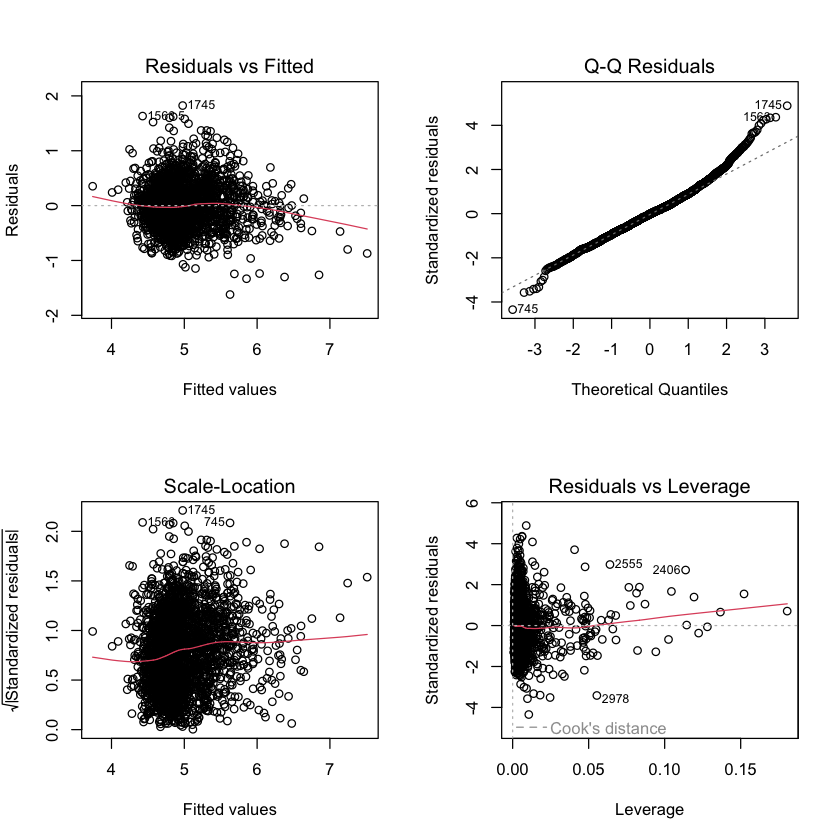

In [14]:
par(mfrow=c(2,2))
plot(lin.fit)

In [15]:
# Adding interaction terms
lin.fit1 = lm(price ~ .+beds*accommodates, data = train)
lin.fit2 = lm(price ~ .+beds*bathrooms, data = train)
lin.fit3 = lm(price ~ .+bathrooms*accommodates, data = train)
lin.fit4 = lm(price ~ .+longitude*latitude, data = train)
stargazer::stargazer(lin.fit1,lin.fit2,lin.fit3,lin.fit4, type="text")


                                            Dependent variable:            
                                -------------------------------------------
                                                   price                   
                                   (1)        (2)        (3)        (4)    
---------------------------------------------------------------------------
longitude                       -0.107***  -0.108***  -0.107***  -0.109*** 
                                 (0.008)    (0.008)    (0.008)    (0.008)  
                                                                           
latitude                        -0.071***  -0.071***  -0.071***  -0.075*** 
                                 (0.008)    (0.008)    (0.008)    (0.008)  
                                                                           
accommodates                     0.190***   0.174***   0.193***   0.186*** 
                                 (0.015)    (0.014)    (0.014)    (0.015)  
           

In [16]:
train_pred = predict(lin.fit1, train)
pred = predict(lin.fit1, test)
mean((train$price - train_pred)**2)
mean((test$price - pred)**2)
summary(lin.fit1)$r.squared

[1] 0.1378588

[1] 0.127123

[1] 0.4947167

In [17]:
train_pred = predict(lin.fit2, train)
pred = predict(lin.fit2, test)
mean((train$price - train_pred)**2)
mean((test$price - pred)**2)
summary(lin.fit2)$r.squared

[1] 0.1371933

[1] 0.1271382

[1] 0.4971558

In [18]:
train_pred = predict(lin.fit3, train)
pred = predict(lin.fit3, test)
mean((train$price - train_pred)**2)
mean((test$price - pred)**2)
summary(lin.fit3)$r.squared

[1] 0.1362611

[1] 0.1269725

[1] 0.5005724

In [19]:
train_pred = predict(lin.fit4, train)
pred = predict(lin.fit4, test)
mean((train$price - train_pred)**2)
mean((test$price - pred)**2)
summary(lin.fit4)$r.squared

[1] 0.1384536

[1] 0.1291125

[1] 0.4925364

# GAM

In [20]:
# Gam with smoothing terms
gam.fit = gam(price ~ host_has_profile_pic + host_identity_verified + instant_bookable + s(longitude) + s(latitude) + s(accommodates) + s(bathrooms) + s(beds) + s(number_of_reviews) + s(review_scores_rating) + s(review_scores_accuracy) + s(review_scores_cleanliness) + s(review_scores_checkin) + s(review_scores_communication) + s(review_scores_location) + s(review_scores_value) + s(reviews_per_month) + s(host_length), data = train)
summary(gam.fit)
pred = predict(gam.fit, test)
mean((test$price - pred)**2)

r2 = 1 - (sum((test$price - pred)^2) / sum((test$price - mean(test$price))^2))
r2


Call: gam(formula = price ~ host_has_profile_pic + host_identity_verified + 
    instant_bookable + s(longitude) + s(latitude) + s(accommodates) + 
    s(bathrooms) + s(beds) + s(number_of_reviews) + s(review_scores_rating) + 
    s(review_scores_accuracy) + s(review_scores_cleanliness) + 
    s(review_scores_checkin) + s(review_scores_communication) + 
    s(review_scores_location) + s(review_scores_value) + s(reviews_per_month) + 
    s(host_length), data = train)
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-1.45751 -0.22618 -0.01233  0.20279  1.64241 

(Dispersion Parameter for gaussian family taken to be 0.1266)

    Null Deviance: 800.4968 on 2933 degrees of freedom
Residual Deviance: 363.3016 on 2870 degrees of freedom
AIC: 2327.532 

Number of Local Scoring Iterations: NA 

Anova for Parametric Effects
                                 Df Sum Sq Mean Sq   F value    Pr(>F)    
host_has_profile_pic              1   0.01   0.010    0.0811  0.775818    
host_i

[1] 0.1193029

[1] 0.5771607

# Random Forest

[1] 0.1096265

[1] 0.6114563

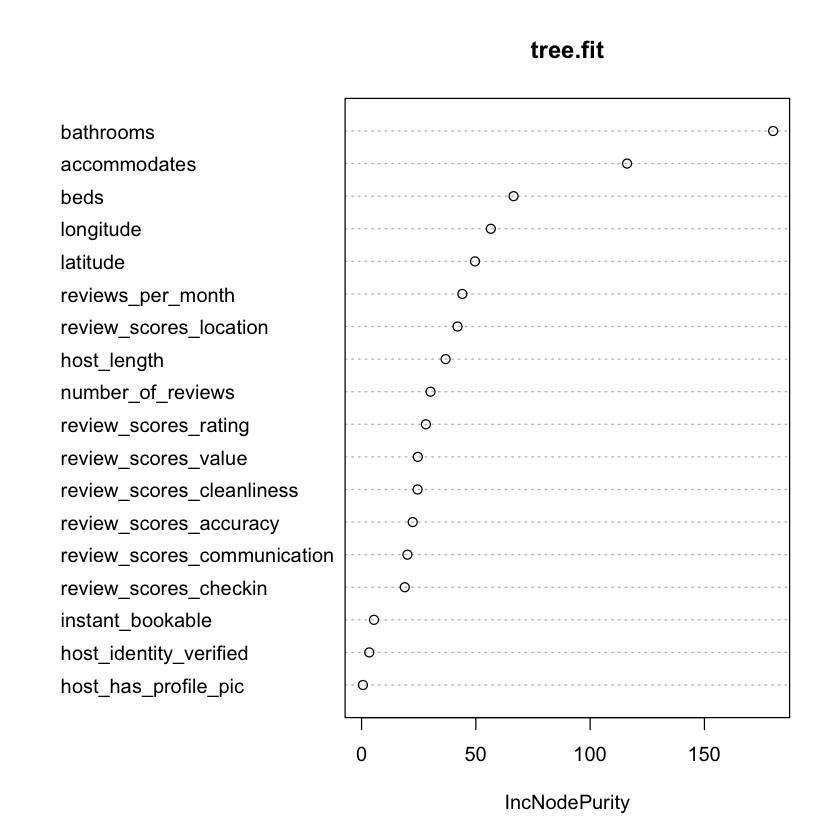

In [21]:
# Random Forest
tree.fit = randomForest(price ~ ., data = train)
# summary(tree.fit)
varImpPlot(tree.fit)
pred = predict(tree.fit, test)
mean((test$price - pred)**2)

r2 = 1 - (sum((test$price - pred)^2) / sum((test$price - mean(test$price))^2))
r2

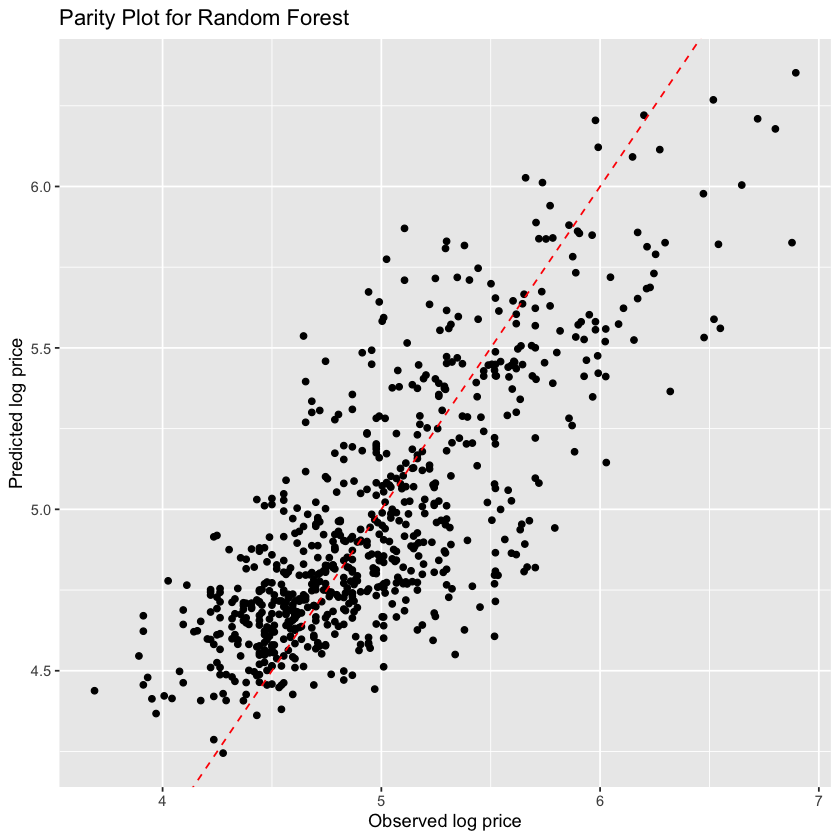

In [22]:
parity_data = data.frame(Observed = test$price, Predicted = pred)

# Create parity plot
ggplot(parity_data, aes(x = Observed, y = Predicted)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") + 
    labs(x = "Observed log price", y = "Predicted log price", title = "Parity Plot for Random Forest")

# SVM

In [23]:
# SVR with radial kernel
svm.fit = svm(price ~ ., data = train)
summary(svm.fit)
pred = predict(svm.fit, test)
mean((test$price - pred)**2)

r2 = 1 - (sum((test$price - pred)^2) / sum((test$price - mean(test$price))^2))
r2


Call:
svm(formula = price ~ ., data = train)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05263158 
    epsilon:  0.1 


Number of Support Vectors:  2534






[1] 0.1198388

[1] 0.5752612

In [77]:
# SVR with linear kernel
svm.fit2 = svm(price ~ ., data = train, kernel = "linear")
summary(svm.fit2)
pred = predict(svm.fit2, test)
mean((test$price - pred)**2)

r2 = 1 - (sum((test$price - pred)^2) / sum((test$price - mean(test$price))^2))
r2


Call:
svm(formula = price ~ ., data = train, kernel = "linear")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  linear 
       cost:  1 
      gamma:  0.05263158 
    epsilon:  0.1 


Number of Support Vectors:  2566






[1] 0.1303891

[1] 0.5378685

In [78]:
# SVR with polynomial kernel
svm.fit3 = svm(price ~ ., data = train, kernel = "polynomial")
summary(svm.fit3)
pred = predict(svm.fit3, test)
mean((test$price - pred)**2)

r2 = 1 - (sum((test$price - pred)^2) / sum((test$price - mean(test$price))^2))
r2


Call:
svm(formula = price ~ ., data = train, kernel = "polynomial")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  polynomial 
       cost:  1 
     degree:  3 
      gamma:  0.05263158 
     coef.0:  0 
    epsilon:  0.1 


Number of Support Vectors:  2561






[1] 0.2691677

[1] 0.04600231

In [64]:
t(svm.fit$coefs) %*% svm.fit$SV

longitude,latitude,accommodates,bathrooms,beds,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_length,host_has_profile_picf,host_has_profile_pict,host_identity_verifiedt,instant_bookablet
-0.2058308,-0.1573055,0.3439041,0.3168383,0.08702399,-0.02452728,0.08443502,0.02117522,0.03434895,-0.001416381,-0.0454288,0.1087022,-0.06875302,-0.04873498,-0.02666533,0.02379943,-0.02379943,-0.1224523,-0.1111788


In [26]:
svm.fit$rho

[1] -0.04149786